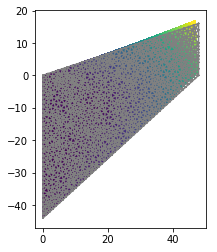

In [2]:
import dolfin
import matplotlib.pyplot as plt
import numpy as np
import mshr

# Mesh and subdomains
ell = 1.0
d = ell/20.
h = d/16.
atol = 1.e-8
domain_vertices = [dolfin.Point(0.0, 0.0),
                  dolfin.Point(0.0, -44.0),
                  dolfin.Point(48.0, 0.0),
                  dolfin.Point(48.0, 16.0)]
domain = mshr.Polygon(domain_vertices)
ndiv = 30
mesh = mshr.generate_mesh(domain,ndiv)
dolfin.plot(mesh)
left = dolfin.CompiledSubDomain('on_boundary && x[0] <= atol', atol=atol)#dolfin.plot(mesh)
#plt.savefig("mesh.png")
# Variational formulation
degree = 1
element = dolfin.VectorElement('P', cell="triangle", degree=degree, dim=mesh.geometric_dimension())
V = dolfin.FunctionSpace(mesh, element)
u = dolfin.Function(V,name="displacement")
u_trial = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

E = 250.0
nu = 0.4999
I2 = dolfin.Identity(mesh.geometric_dimension())
mu = dolfin.Constant(E/2./(1.+nu))
lambda_ = dolfin.Constant(E*nu/(1.+nu)/(1.-2.*nu))

def strain_displacement(u):
    return dolfin.sym(dolfin.grad(u))

def stress_strain(eps):
    return lambda_*dolfin.tr(eps)*I2+2*mu*eps

bilinear_form = dolfin.inner(stress_strain(strain_displacement(u_trial)),
                             strain_displacement(v))*dolfin.dx

traction = dolfin.Expression(('x[0] < x_right ? 0.0 : -12.*M/d/d/d*x[1]', '0.0'),
                             x_right=ell-atol, M=1.0, d=d, degree=degree)

linear_form = dolfin.dot(traction, v)*dolfin.ds

u_prescribed = dolfin.Constant((0., 0.))
boundary_condition_left = dolfin.DirichletBC(V, u_prescribed, left)
boundary_conditions = [boundary_condition_left]

problem = dolfin.LinearVariationalProblem(bilinear_form, linear_form, u, boundary_conditions)

solver = dolfin.LinearVariationalSolver(problem)
solver.solve()

dolfin.plot(u/u.vector().max(),mode="displacement")
plt.savefig("u.png")

with dolfin.XDMFFile(mesh.mpi_comm(), "output/u.xdmf") as file:
        file.write(u,  0)

V = 100. ?

u_ufl ?